# Evaluation of performance of Coulomb force evaluation

In this notebook we have a quick look at the performance of the Coulomb force evalution and our optimizations. The timing results in this notebook were obtained on a low end AMD A6 laptop CPU.

In [1]:
import coldatoms
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import time

We evaluate the performance by doing a few force evalutations and measuring the elapsed time:

In [3]:
def measure_time(num_ptcls, per_ptcl_charges=False, num_iter=1, use_reference_impl=False):
    ensemble = coldatoms.Ensemble(num_ptcls=num_ptcls)
    ensemble.x = np.random.random([num_ptcls, 3])
    if per_ptcl_charges:
        ensemble.set_particle_properties('charge', np.random.random(num_ptcls))
    else:
        ensemble.ensemble_properties['charge'] = 1.0
    
    f = coldatoms.CoulombForce()
    if use_reference_impl:
        f.use_reference_implementations()
        
    t0 = time.time()
    for i in range(num_iter):
        f.force(1.0e-1, ensemble)
    t1 = time.time()
    return t1 - t0

We consider particle numbers on a logarithmic scale:

In [2]:
def num_ptcls(n_min, n_max, n):
    return [n_min * (n_max / n_min)**(i/(n - 1)) for i in range(n)]

Here is the performance of the naive C implementation

<IPython.core.display.Javascript object>


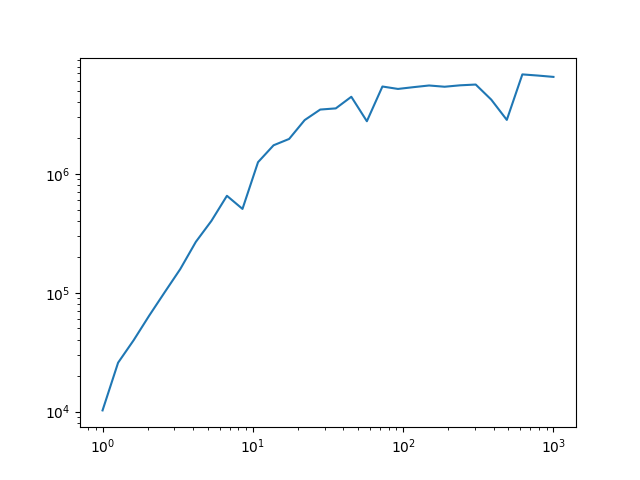

In [6]:
nptcls = np.array(num_ptcls(1, 1000, 30))
times = np.array([measure_time(int(round(n)), num_iter=5) for n in nptcls])
pairs_per_second = nptcls**2 / times
plt.figure()
plt.loglog(nptcls, pairs_per_second)

The latency can be inferred from the time it takes to deal with just one pair:

In [7]:
times[0]

9.7751617431640625e-05

In the limit of large numbers of particles we process on the order of $6\times 10^6$ particle pairs per second:

In [8]:
pairs_per_second[-1]

6543488.2657892723

For the numbers of particles considered here we do not observe any cache effects yet. This could be due to inefficiencies in the force evaluation function or due to the relatively small number of particles (Easily fits in L2, almost fits into L1 cache). We can model the processing speed using latency and the processing speed at large numbers of particles.

In [9]:
def const_rate_model(latency, rate, num_ptcls):
    num_pairs = num_ptcls**2
    total_time = latency + num_pairs / rate
    return num_pairs / total_time

<IPython.core.display.Javascript object>


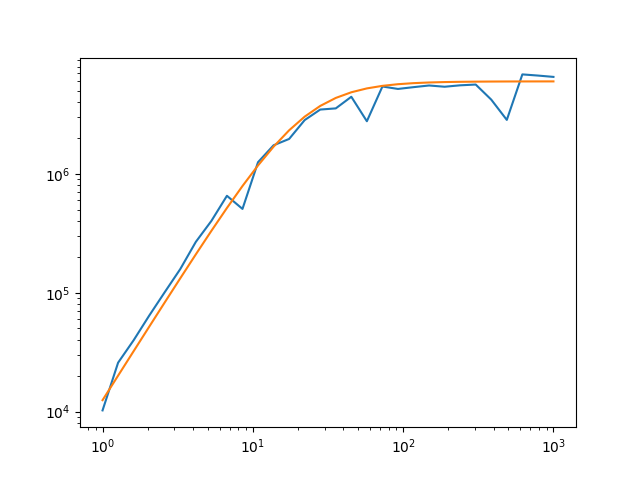

In [15]:
plt.figure()
plt.loglog(nptcls, pairs_per_second)
plt.loglog(nptcls, [const_rate_model(0.8e-4, 6.0e6, n) for n in nptcls])